### Our approach will be to define an "anomaly" as being some pattern in the waveform that hasn't been seen before.

Our algorithm will build up a library of "normal" waveform shapes, and use that library to try and reconstruct a waveform to be tested. If the reconstruction is poor, then the waveform is likely to contain something abnormal, and is therefore anomalous.

#### In summary, our algorithm will be:
Training:
Split waveform data into segments of n samples

Form a space in n dimensions, with each segment representing one point

Determine clustering of segment points, and determine the centres or centroids of the clusters

Cluster centroids provide library of "normal" waveform shapes

Testing:

Try to reconstruct waveform data to be tested using cluster centroids learned during training


Poor reconstruction error on any individual segment indicates anomalous shape

In [4]:
from __future__ import print_function
import ekg_data
import warnings
warnings.filterwarnings('ignore')

ekg_filename = 'a02.dat'
ekg_data = ekg_data.read_ekg_data(ekg_filename)
print(ekg_data.shape)
ekg_data

(3182000L,)


array([-4., -4., -5., ...,  0.,  0.,  0.])

In [5]:
#data starts from heartbeat of -4 and ranges beetween -572 to 580

print("ekg_data[0]:\t", ekg_data[0])
print("ekg_data[1]:\t", ekg_data[100])
print("ekg_data.min:\t", ekg_data.min())
print("ekg_data.max:\t", ekg_data.max())

ekg_data[0]:	 -4.0
ekg_data[1]:	 -20.0
ekg_data.min:	 -572.0
ekg_data.max:	 580.0


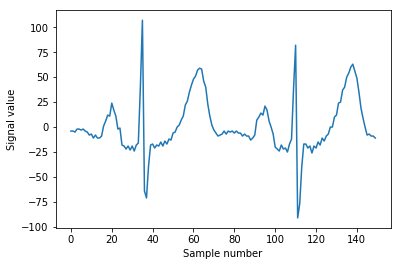

In [6]:
# IPython 'magic' command to set the matplotlib backend to display
# in the notebook
%matplotlib inline

import matplotlib.pyplot as plt

n_samples_to_plot = 150
plt.plot(ekg_data[0:n_samples_to_plot])  #plot first 300 data points
plt.xlabel("Sample number")
plt.ylabel("Signal value")
plt.show()

In [7]:
#as the data is huge lets experiment on forst 90k values
ekg_data = ekg_data[0:9000]

First, we'll need to split the waveform into segments to give us separate "samples". But what will our features be - what are the variables that will define the n-dimensional space? We could go with standard measurements of each segment such as maximum, minimum and spread. But since our technique is generalisable to any number of dimensions, we can do something a bit more clever: we can take each element of the segment as a separate dimension. For a segment containing 32 time values, we define a 32-dimensional space. It is in this 32-dimensional space that we will form our clusters of waveform segments.

In [8]:
#The first step in our process is to split the waveform into overlapping segments, 
#with the section of the original data sampled sliding along by two samples each time. 
#We take this approach so that we get instances of each waveform shape with a variety of horizontal translations.

In [9]:
import numpy as np

segment_len = 32  #split the data into 32 segments
slide_len = 2  #step of two

segments = []
for start_pos in range(0, len(ekg_data), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original ekg_data
    segment = np.copy(ekg_data[start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))
print("length of each segment is", len(segments[1]))

Produced 4485 waveform segments
length of each segment is 32


In [10]:
ekg_data[0:10] #created a 32 value array of step 2

array([-4., -4., -5., -2., -2., -3., -2., -4., -5., -8.])

In [11]:
segments[1:3] #here the first array sonsists of first 32 points 
#second array consits of data from second index to 34 index and so onn
#we have 4081 such arrays

[array([ -5.,  -2.,  -2.,  -3.,  -2.,  -4.,  -5.,  -8.,  -7., -11.,  -8.,
        -11., -11.,  -9.,   1.,   6.,  12.,  11.,  24.,  17.,  11.,  -2.,
         -1., -18., -19., -22., -19., -23., -19., -24., -18., -16.]),
 array([  -2.,   -3.,   -2.,   -4.,   -5.,   -8.,   -7.,  -11.,   -8.,
         -11.,  -11.,   -9.,    1.,    6.,   12.,   11.,   24.,   17.,
          11.,   -2.,   -1.,  -18.,  -19.,  -22.,  -19.,  -23.,  -19.,
         -24.,  -18.,  -16.,   40.,  107.])]

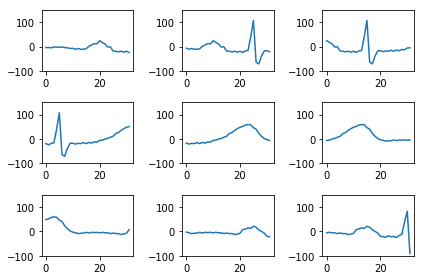

In [12]:
#lets plot and see how each segment looks like

import learn_utils
learn_utils.plot_waves(segments, step=5)

Although this is fine but inorder to merge these plots we need to have every plot starting with zero and ending with zero.
since the learned "normal" segment will then also have non-zero starts and end, when we try to reconstruct our waveform to be tested by adding together our learned segment, we'll end up with discontinuities.

To avoid this we will apply window function

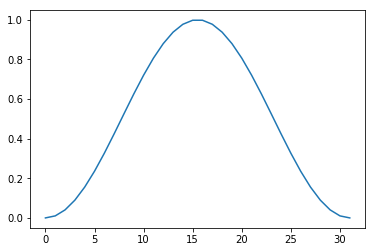

In [13]:
#inorder to start and end an array with zero we need to create a window function which starts and endds
#with zero and multiply this window function to the segments
#a simple window function can be sine wave

window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
plt.plot(window)
plt.show()  

In [14]:
window #the array of sine wave

array([  0.00000000e+00,   1.02350294e-02,   4.05210942e-02,
         8.96182794e-02,   1.55516540e-01,   2.35517995e-01,
         3.26347374e-01,   4.24286111e-01,   5.25324584e-01,
         6.25326266e-01,   7.20197076e-01,   8.06052991e-01,
         8.79379061e-01,   9.37173308e-01,   9.77069628e-01,
         9.97434662e-01,   9.97434662e-01,   9.77069628e-01,
         9.37173308e-01,   8.79379061e-01,   8.06052991e-01,
         7.20197076e-01,   6.25326266e-01,   5.25324584e-01,
         4.24286111e-01,   3.26347374e-01,   2.35517995e-01,
         1.55516540e-01,   8.96182794e-02,   4.05210942e-02,
         1.02350294e-02,   1.49975978e-32])

In [15]:
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window #multiplying the array with sine wave signal
    windowed_segments.append(windowed_segment) #which results in array where start and end are zero

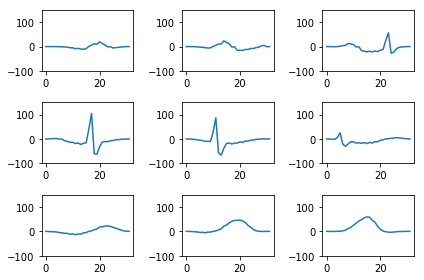

In [16]:
#in this way we can create more concentrated data in the middle
learn_utils.plot_waves(windowed_segments, step=3)

In [17]:
windowed_segments[2] #sample array of windowed data where it starts and ends with zero

array([ -0.00000000e+00,  -3.07050881e-02,  -8.10421884e-02,
        -3.58473118e-01,  -7.77582702e-01,  -1.88414396e+00,
        -2.28443162e+00,  -4.66714722e+00,  -4.20259668e+00,
        -6.87858893e+00,  -7.92216783e+00,  -7.25447692e+00,
         8.79379061e-01,   5.62303985e+00,   1.17248355e+01,
         1.09717813e+01,   2.39384319e+01,   1.66101837e+01,
         1.03089064e+01,  -1.75875812e+00,  -8.06052991e-01,
        -1.29635474e+01,  -1.18811991e+01,  -1.15571409e+01,
        -8.06143611e+00,  -7.50598959e+00,  -4.47484190e+00,
        -3.73239697e+00,  -1.61312903e+00,  -6.48337507e-01,
         4.09401175e-01,   1.60474297e-30])

### Clustering

#### Consider our 32-dimensional waveform space. Each point in this space represents a possible waveform segment. Similar segments will cluster together. The middle of each cluster (the centroid) will provide some measure of the prototypical waveform pattern that all those segments are specific instances of. (If this is difficult to visualise, the other way to consider it is that the centroid is simply an average of all waveform samples in that cluster.)
Note that the centroid, being a point in the waveform space, is itself a waveform. Thus, the cluster centroids provide us with a set of "normal" waveform segments.
Suppose we then try to use our set of "normal" segments to reconstruct a set of data to be tested. If the data is similar in shape to what has come before it, we will be able to manage a good reconstruction. However, if the data contains some abnormal shape, we will not be able to reconstruct it using our normal shape library, and we will get a reconstruction error. This error will indicate an anomaly!

In [38]:
#lets apply k-means on the 32 dimensional spppend(clusters.inace
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=161)
clusterer.fit(windowed_segments)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=161, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

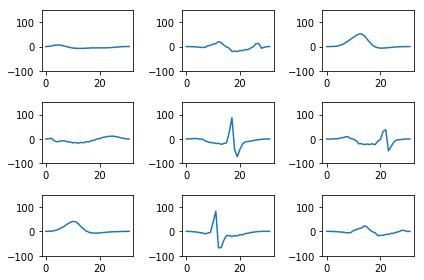

In [39]:
#visualizing the cluster array points
learn_utils.plot_waves(clusterer.cluster_centers_, step=3)

Finally, we come to the interesting part of the algorithm: reconstructing our waveform to be tested using the learned library of shapes. Our approach is going to be very simple. We'll:

Split the data into overlapping segments

Find the cluster centroid which best matches our segment

Use that centroid as the reconstruction for that segment

Join the reconstruction segments up to form the reconstruction

This time, we only need enough overlap between segments to allow us to stitch the reconstructions back together again, so we'll go with an overlap of half a segment.
First, let's see how well we do at reconstructing the original waveform. We first form segments:

Before trying to reconstruct the whole thing, we can check how the reconstruction fares for individual segments. Try changing the segment index to see the reconstruction for different segments.

C:\Users\mohad\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


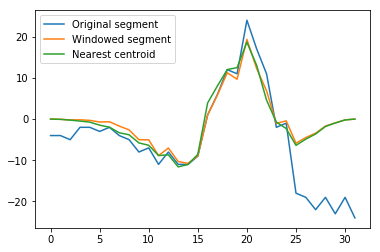

In [33]:
#lets take a segment and try plotting our original segment, windowed segment and nearesr centroid

#creating a 16 step window for a braoder view
slide_len = segment_len/2
test_segments = learn_utils.sliding_chunker(
    ekg_data,
    window_len=segment_len,
    slide_len=slide_len
)


centroids = clusterer.cluster_centers_

segment = np.copy(test_segments[0]) #the first array of origianl segment
# remember, the clustering was set up using the windowed data
# so to find a match, we should also window our search key
windowed_segment = segment * window  #the windowed data
# predict() returns a list of centres to cope with the possibility of multiple
# samples being passed
nearest_centroid_idx = clusterer.predict(windowed_segment)[0]  #the centroid of each point and 
nearest_centroid = np.copy(centroids[nearest_centroid_idx])  #taking centroids of only the points which are in window segment
plt.figure()
plt.plot(segment, label="Original segment")
plt.plot(windowed_segment, label="Windowed segment")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.legend()
plt.show()

C:\Users\mohad\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\mohad\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\mohad\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarn

Maximum reconstruction error was 10.6


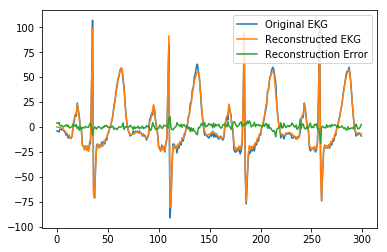

In [34]:
#lets plot the first 300 sample points and see the error

reconstruction = np.zeros(len(ekg_data))
slide_len = segment_len/2

for segment_n, segment in enumerate(test_segments):
    # don't modify the data in segments
    segment = np.copy(segment)  
    segment *= window
    nearest_centroid_idx = clusterer.predict(segment)[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx]) #taking the centroids for each data point and 
    #creating a wave out of it
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = segment_n * slide_len
    reconstruction[pos:pos+segment_len] += nearest_centroid  #this is the data of centroid of each point
    

n_plot_samples = 300

error = reconstruction[0:n_plot_samples] - ekg_data[0:n_plot_samples] #the difference of 
#real data i.e our reconstructed data with respect to real data i.e ekg_data is the error
#error_98th_percentile = np.percentile(error, 98) #
print("Maximum reconstruction error was %.1f" % error.max()) #printing the error
#print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

#plotting the data
plt.plot(ekg_data[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

In [35]:
#adding noise and testing our detector
ekg_data_anomalous = np.copy(ekg_data)
ekg_data_anomalous[210:215] = 0

C:\Users\mohad\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\mohad\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\mohad\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarn

Maximum reconstruction error was 55.6


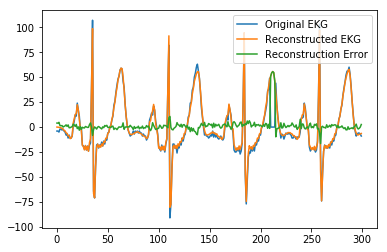

In [36]:
#bringing our reconstruction data
recontruction = learn_utils.reconstruct(ekg_data_anomalous, window, clusterer)
    
#plotting with the anomalous data
error = reconstruction[0:n_plot_samples] - ekg_data_anomalous[0:n_plot_samples]
#error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
#print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(ekg_data_anomalous[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

Since our anomaly has produced a shape in the waveform that hadn't been seen before, the waveform around that point couldn't be reconstructed using the learned shape library. This gives a large, easily visible reconstruction error! This error could be easily detected using a simple threshold detector.